In [53]:
%pip install pandas scikit-learn xgboost tensorflow joblib

Note: you may need to restart the kernel to use updated packages.


In [54]:
# train_models.py
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from joblib import dump
import tensorflow as tf

# ------------------------------------------------------------------
# 1. Carga de datos
# ------------------------------------------------------------------
DATA_DIR = Path('.')          # ajusta si lo necesitas
train_df = pd.read_csv(DATA_DIR / 'train.csv')
val_df   = pd.read_csv(DATA_DIR / 'val.csv')
test_df  = pd.read_csv(DATA_DIR / 'test.csv')

target_col  = 'result'

# ------------------------------------------------------------------
# Cargar cadenas de MArkov
# ------------------------------------------------------------------
SPACE = " "
def str_to_vec(s: str) -> np.ndarray:
    """Convierte la cadena '0.123 0.0 …' en vector float32."""
    return np.fromstring(s, sep=SPACE, dtype=np.float32)

def build_feature_matrix(df: pd.DataFrame) -> np.ndarray:
    """
    Output:  [simhash, astsimilarity,  markov1(flat) , markov2(flat) , |diff| ]
              └─2 cols──┘          └────────── 3 x L  ───────────────┘
    """
    base   = df[["simhash", "astsimilarity"]].values.astype("float32")

    m1 = np.vstack(df["markov1"].apply(str_to_vec))
    m2 = np.vstack(df["markov2"].apply(str_to_vec))
    diff = np.abs(m1 - m2)

    return np.hstack([base, m1, m2, diff])

vlen   = len(str_to_vec(train_df["markov1"].iloc[0]))
dim_v  = int(np.sqrt(vlen))
print(f"Vocab Markov detectado: {dim_v} nodos  =>  {vlen} números por matriz")


Vocab Markov detectado: 52 nodos  =>  2704 números por matriz


In [55]:


feature_cols = ["simhash", "astsimilarity"]

X_train = build_feature_matrix(train_df)
X_val   = build_feature_matrix(val_df)
X_test  = build_feature_matrix(test_df)

y_train = train_df[target_col].astype("int8").values
y_val   = val_df  [target_col].astype("int8").values
y_test  = test_df [target_col].astype("int8").values

# ------------------------------------------------------------------
# 2. Pre-procesamiento: escalamos numéricos
# ------------------------------------------------------------------
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)


In [56]:

# ------------------------------------------------------------------
# 3. Modelo 0 — Baseline con TensorFlow
# ------------------------------------------------------------------
def build_tf_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1,  activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

tf_model = build_tf_model(X_train_sc.shape[1])



In [57]:
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

# callback para medir test accuracy al final de cada época
test_accuracies = []
test_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: test_accuracies.append(
        tf_model.evaluate(X_test_sc, y_test, verbose=0)[1]
    )
)

history = tf_model.fit(
    X_train_sc, y_train,
    validation_data=(X_val_sc, y_val),
    epochs=50, batch_size=256, verbose=0,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        test_callback
    ]
)

print('\n🟢 TensorFlow — Test metrics')
tf_metrics = tf_model.evaluate(X_test_sc, y_test, verbose=0)
for name, val in zip(tf_model.metrics_names, tf_metrics):
    print(f'{name}: {val:.4f}')
tf_model.save('tf_baseline.keras')


🟢 TensorFlow — Test metrics
loss: 0.4528
accuracy: 0.7831
auc: 0.8928


In [58]:

# ------------------------------------------------------------------
# 4. Modelo 1 — Regresión logística
# ------------------------------------------------------------------
logreg = LogisticRegression()
logreg.fit(X_train_sc, y_train)
print('\n🟢 LogReg — Val accuracy:',
      accuracy_score(y_val, logreg.predict(X_val_sc)))
dump(('scaler', scaler, 'logreg', logreg), 'logreg.joblib')



🟢 LogReg — Val accuracy: 0.7157190635451505


c:\Users\pablo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['logreg.joblib']

In [59]:

# ------------------------------------------------------------------
# 5. Modelo 2 — Random Forest
# ------------------------------------------------------------------
rf = RandomForestClassifier()
rf.fit(X_train, y_train)                  # RF no necesita escalado
print('\n🟢 RandomForest — Val accuracy:',
      accuracy_score(y_val, rf.predict(X_val)))
dump(rf, 'rf.joblib')



🟢 RandomForest — Val accuracy: 0.7324414715719063


['rf.joblib']

In [60]:

# ------------------------------------------------------------------
# 6. Modelo 3 — XGBoost
# ------------------------------------------------------------------
xgb_clf = XGBClassifier()

xgb_clf.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False)

evals_result = xgb_clf.evals_result()

print('\n🟢 XGBoost — Val accuracy:',
      accuracy_score(y_val, (xgb_clf.predict(X_val) > 0.5)))
xgb_clf.save_model('xgb.json')



🟢 XGBoost — Val accuracy: 0.7926421404682275


In [61]:

# ------------------------------------------------------------------
# 7. Comparación final en TEST
# ------------------------------------------------------------------
def evaluate(name, y_true, y_pred, y_prob):
    print(f'🔸 {name}: acc={accuracy_score(y_true, y_pred):.4f}',
          f'f1={f1_score(y_true, y_pred):.4f}',
          f'auc={roc_auc_score(y_true, y_prob):.4f}')

print('\n📊  Métricas finales en TEST:')
evaluate('LogReg',
         y_test,
         logreg.predict(X_test_sc),
         logreg.predict_proba(X_test_sc)[:,1])

evaluate('RandomForest',
         y_test,
         rf.predict(X_test),
         rf.predict_proba(X_test)[:,1])

evaluate("XGBoost",
         y_test,
         (xgb_clf.predict(X_test) > 0.5),
         xgb_clf.predict_proba(X_test)[:,1])

tf_pred_prob = tf_model.predict(X_test_sc).ravel()
tf_pred_bin  = (tf_pred_prob > 0.5).astype(int)
evaluate("TensorFlow", y_test, tf_pred_bin, tf_pred_prob)



📊  Métricas finales en TEST:
🔸 LogReg: acc=0.7651 f1=0.7174 auc=0.8784
🔸 RandomForest: acc=0.8133 f1=0.7919 auc=0.9015
🔸 XGBoost: acc=0.8584 f1=0.8459 auc=0.9276
11/11 [==============================] - 0s 1ms/step
🔸 TensorFlow: acc=0.7831 f1=0.7447 auc=0.8926


11/11 [==============================] - 0s 2ms/step


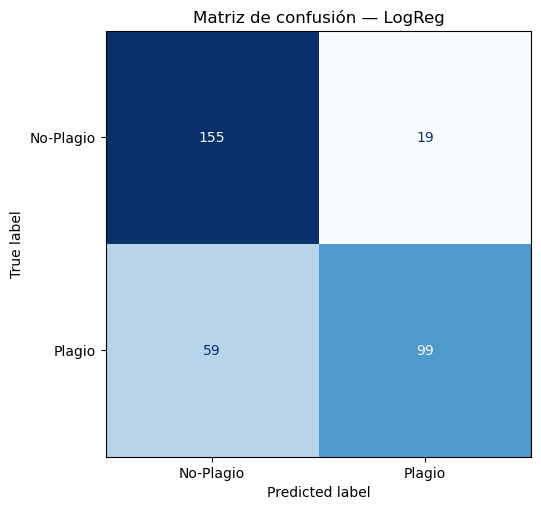


Reporte de clasificación — LogReg
              precision    recall  f1-score   support

   No-Plagio       0.72      0.89      0.80       174
      Plagio       0.84      0.63      0.72       158

    accuracy                           0.77       332
   macro avg       0.78      0.76      0.76       332
weighted avg       0.78      0.77      0.76       332



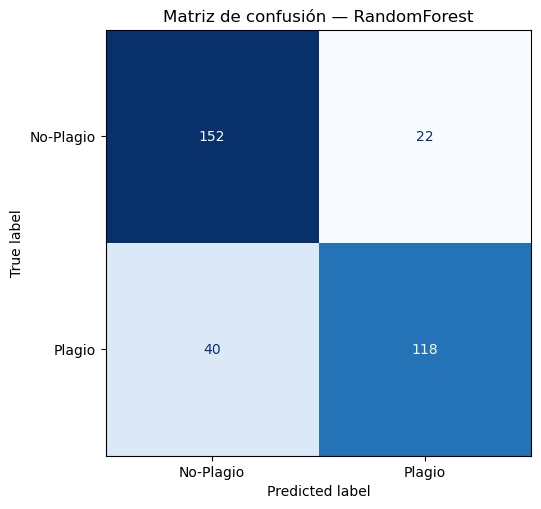


Reporte de clasificación — RandomForest
              precision    recall  f1-score   support

   No-Plagio       0.79      0.87      0.83       174
      Plagio       0.84      0.75      0.79       158

    accuracy                           0.81       332
   macro avg       0.82      0.81      0.81       332
weighted avg       0.82      0.81      0.81       332



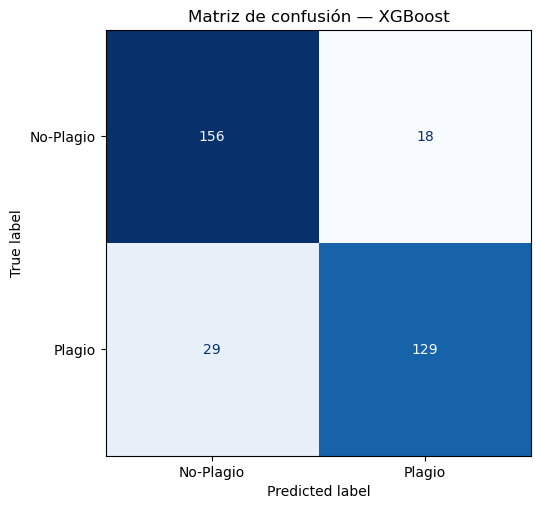


Reporte de clasificación — XGBoost
              precision    recall  f1-score   support

   No-Plagio       0.84      0.90      0.87       174
      Plagio       0.88      0.82      0.85       158

    accuracy                           0.86       332
   macro avg       0.86      0.86      0.86       332
weighted avg       0.86      0.86      0.86       332



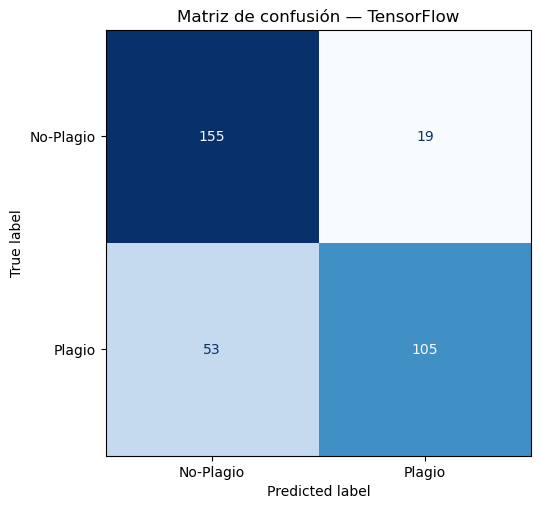


Reporte de clasificación — TensorFlow
              precision    recall  f1-score   support

   No-Plagio       0.75      0.89      0.81       174
      Plagio       0.85      0.66      0.74       158

    accuracy                           0.78       332
   macro avg       0.80      0.78      0.78       332
weighted avg       0.79      0.78      0.78       332



In [62]:
# ---------------------------------------------------------------
#  MATRICES DE CONFUSIÓN (set de TEST)
# ---------------------------------------------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

plt.rcParams["figure.figsize"] = (5.5, 5.5)

# --- predicciones ------------------------------------------------
y_pred_logreg = logreg.predict(X_test_sc)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = (xgb_clf.predict(X_test) > 0.5).astype(int)
tf_prob = tf_model.predict(X_test_sc).ravel()
y_pred_tf = (tf_prob > 0.5).astype(int)

# --- modelos + preds en un dict ---------------------------------
models = {
    "LogReg" : y_pred_logreg,
    "RandomForest" : y_pred_rf,
    "XGBoost" : y_pred_xgb,
    "TensorFlow" : y_pred_tf
}

# --- dibuja e imprime -------------------------------------------
for name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["No-Plagio", "Plagio"])
    fig, ax = plt.subplots()
    disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
    ax.set_title(f"Matriz de confusión — {name}")
    plt.tight_layout()
    plt.show()

    print(f"\nReporte de clasificación — {name}")
    print(classification_report(y_test, y_pred,
                                target_names=["No-Plagio", "Plagio"]))


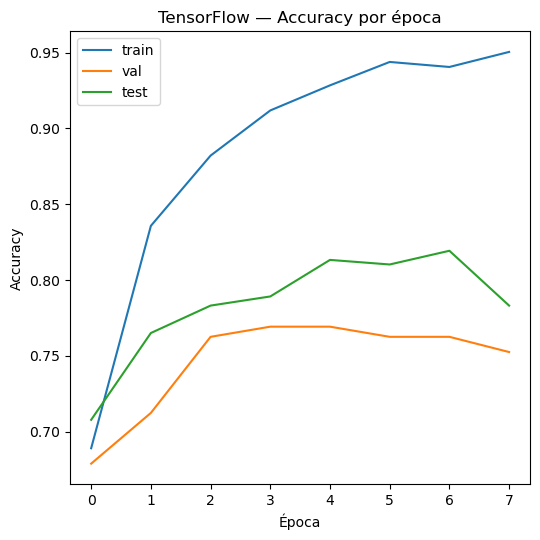

In [63]:
# ---------------------------------------------------------------
#  Graficas de entrenamiento
# ---------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'],    label='train')
plt.plot(history.history['val_accuracy'],label='val')
plt.plot(test_accuracies,               label='test')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('TensorFlow — Accuracy por época')
plt.legend()
plt.tight_layout()
plt.show()